In this notebook we will use the same Cython code as in the last notebook. However, this time we will use the `Vode` integrator from `ODEPACK` (available in SciPy in `scipy.integrate.ode`). The reason for this is that it will be a fairer comparison against our upcoming example using `CVode`.

In [1]:
import json
import numpy as np

Subclassing `ODEsys` and providing a new method using `scipy.integrate.ode`:

In [2]:
# %load ../scipy2017codegen/odesys_vode.py
import numpy as np
from scipy.integrate import ode
from scipy2017codegen.odesys import ODEsys

class VODEsys(ODEsys):
    default_integrator = 'vode'

    def integrate_vode(self, tout, y0, params=(), method='bdf', rtol=1e-8, atol=1e-8, **kwargs):
        def f(t, y, *args):
            f.ncall +=1
            return np.asarray(self.f_eval(y, t, *args))
        f.ncall = 0
        def j(t, y, *args):
            j.ncall += 1
            return np.asarray(self.j_eval(y, t, *args))
        j.ncall = 0
        r = ode(f, j)
        r.set_integrator('vode', method=method, rtol=rtol, atol=atol, **kwargs)
        if params:
            r.set_f_params(params)
            r.set_jac_params(params)
        yout = np.zeros((len(tout), len(y0)))
        yout[0, :] = y0
        r.set_initial_value(yout[0, :], tout[0])
        for idx in range(1, len(tout)):
            r.integrate(tout[idx])
            assert r.successful(), "Integration failed"
            yout[idx, :] = r.y
        return yout, {'num_rhs': f.ncall, 'num_dls_jac_evals': j.ncall}


Creating a new mixin class:

In [3]:
from scipy2017codegen.odesys_cython import CythonODEsys

class CythonVODEsys(VODEsys, CythonODEsys):
    pass

Same procedure as in the last notebook:

In [4]:
from scipy2017codegen.chem import mk_rsys

In [5]:
watrad_data = json.load(open('../scipy2017codegen/data/radiolysis_300_Gy_s.json'))
watrad = mk_rsys(ODEsys, **watrad_data)
tout = np.logspace(-6, 3, 200)  # close to one hour of operation
c0 = {'H2O': 55.4e3, 'H+': 1e-4, 'OH-': 1e-4}
y0 = [c0.get(symb.name, 0) for symb in watrad.y]

In [6]:
cython_sys = mk_rsys(CythonVODEsys, **watrad_data)

In [7]:
%timeit cython_sys.integrate(tout, y0)

3.89 s ± 222 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That is a considerably slower than `odeint`. It is clear that it is the python wrapper (in scipy) that is the bottleneck. Especially since using `Vode` and choosing `BDF` for this stiff problem will avoid the method swaps LSODA attempts.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Just to see that everything looks alright:

The rhs was evaluated 1096 times and the jacobian 19 times


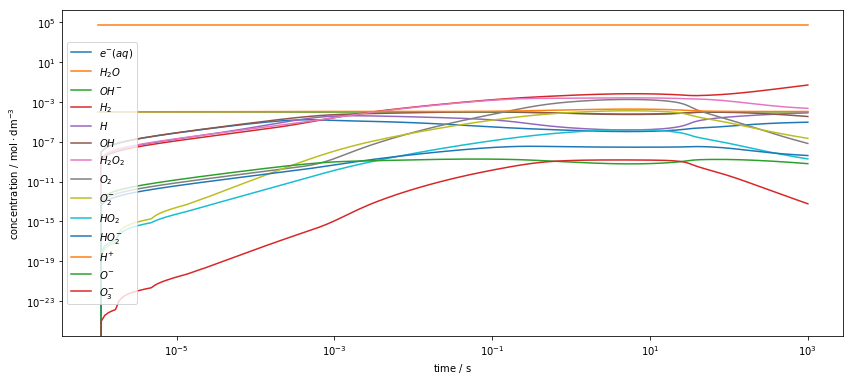

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
cython_sys.plot_result(tout, *cython_sys.integrate_vode(tout, y0), ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')